In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload

In [2]:
import sys
sys.path.append('../')

In [3]:
%%writefile ../src/full_agent.py

"""This code contains the code for the logistician agent"""

import os
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver

from src.supervisor_schema import AgentInputState
from src.supervisor_agent import DelegateNextAgent, clarify_with_user, supervisor_agent, supervisor_tools
from src.logistics_agent import LogisticsAgent , LogisticsState
from src.forwarder_agent import ForwarderAgent

# Build the scoping workflow
full_agent_builder = StateGraph(LogisticsState, input_schema=AgentInputState)

# Add workflow nodes
full_agent_builder.add_node("supervisor_agent"  , supervisor_agent)
full_agent_builder.add_node("supervisor_tools"  , supervisor_tools)
full_agent_builder.add_node("clarify_with_user" , clarify_with_user)
full_agent_builder.add_node("LogisticsAgent"    , LogisticsAgent)
full_agent_builder.add_node("ForwarderAgent"    , ForwarderAgent)

# Add workflow edges
full_agent_builder.add_edge(START, "supervisor_agent")
full_agent_builder.add_conditional_edges(
    "supervisor_agent",
     DelegateNextAgent,
    {
        "supervisor_tools"  : "supervisor_tools" , 
        "clarify_with_user" : "clarify_with_user", 
        "logistics_agent"   : "LogisticsAgent"   ,
        "forwarder_agent"   : "ForwarderAgent"
    },
)
full_agent_builder.add_edge("supervisor_tools", "supervisor_agent")
full_agent_builder.add_edge("clarify_with_user", END)

# Compile the workflow
checkpointer = InMemorySaver()
full_agent = full_agent_builder.compile(checkpointer = checkpointer)

Overwriting ../src/full_agent.py


c:\Users\kamalmo\Desktop\AI\InboundLogisticSystem\MultiAgentInboundLogistic\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


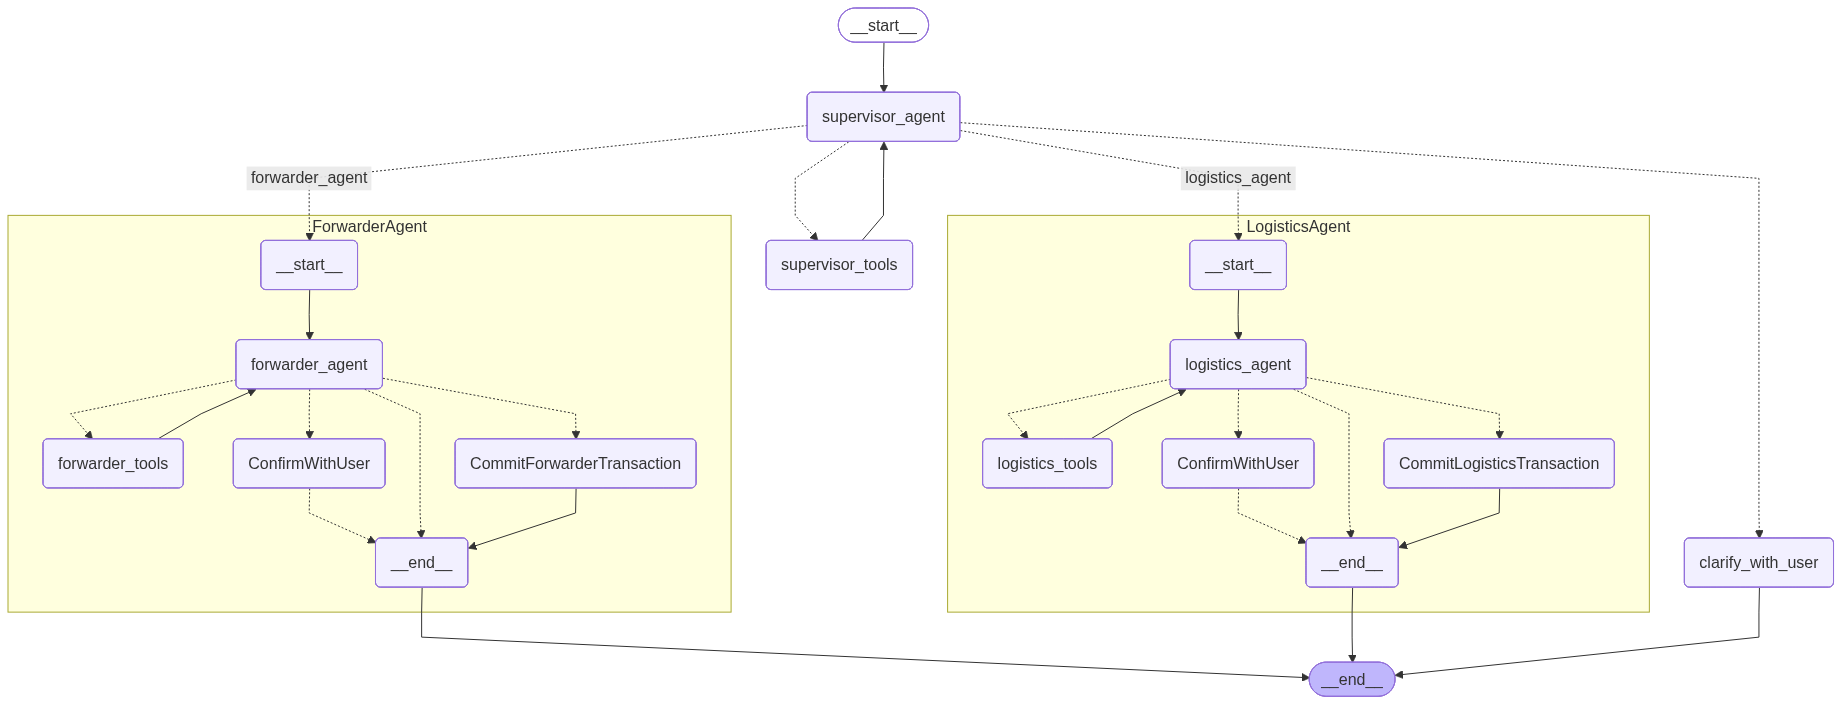

In [4]:
from IPython.display import Image, display
from src.full_agent import full_agent

# Show the agent
display(Image(full_agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
from src.utils import format_message
from langchain_core.messages import HumanMessage
from src.full_agent import full_agent

thread = {"configurable":{"thread_id":"1"}}
result = await full_agent.ainvoke({"messages":[HumanMessage(content="I want to enter the AWB/BL 12345")]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to enter the AWB/BL 12345                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the AWB/BL number as 12345. This field is required and relates to the Logistics           │
│ Department. Assigning this task to the Logistics Agent for further handling.                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Field:**                                                                                   │
│ - Shipment_Mode                                                                                                 │
│                                                                                                                 │
│ Please provide the missing information so I can proceed with your request. If you need help or clarification    │
│ about what to enter, let me know!                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [6]:
result = await full_agent.ainvoke({"messages":[HumanMessage(content="Skip")]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to enter the AWB/BL 12345                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the AWB/BL number as 12345. This field is required and relates to the Logistics           │
│ Department. Assigning this task to the Logistics Agent for further handling.                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Field:**                                                                                   │
│ - Shipment_Mode                                                                                                 │
│                                                                                                                 │
│ Please provide the missing information so I can proceed with your request. If you need help or clarification    │
│ about what to enter, let me know!                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Skip                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the AWB/BL number as 12345 and chose to skip entering the Shipment Mode at this time.     │
│ Assigning this task to the Logistics Agent for further handling with the available information.                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Field:**                                                                                   │
│ Your request is missing the following required information:                                                     │
│ - **Shipment_Mode**                                                                                             │
│                                                                                                                 │
│ Please provide this field so we can proceed. If you need help or clarification, let me know!                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [7]:
result = await full_agent.ainvoke({"messages":[HumanMessage(content="The Shipment Mode is Air")]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to enter the AWB/BL 12345                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the AWB/BL number as 12345. This field is required and relates to the Logistics           │
│ Department. Assigning this task to the Logistics Agent for further handling.                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Field:**                                                                                   │
│ - Shipment_Mode                                                                                                 │
│                                                                                                                 │
│ Please provide the missing information so I can proceed with your request. If you need help or clarification    │
│ about what to enter, let me know!                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Skip                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the AWB/BL number as 12345 and chose to skip entering the Shipment Mode at this time.     │
│ Assigning this task to the Logistics Agent for further handling with the available information.                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Field:**                                                                                   │
│ Your request is missing the following required information:                                                     │
│ - **Shipment_Mode**                                                                                             │
│                                                                                                                 │
│ Please provide this field so we can proceed. If you need help or clarification, let me know!                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The Shipment Mode is Air                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the following inbound logistics data: AWB/BL number: 12345 and Shipment Mode: Air. The    │
│ user initially skipped the Shipment Mode but later provided it. No further clarification is needed. Assigning   │
│ this task to the Logistics Agent for further handling with the provided information.                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Some optional fields are missing from your submission:                                                          │
│ - Product_Temperature                                                                                           │
│                                                                                                                 │
│ You can provide this information now to complete your record, or let me know if you'd like to skip it and       │
│ proceed. If you prefer, you can also add it later. Please reply with the missing details, or tell me how you'd  │
│ like to continue.                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
result = await full_agent.ainvoke({"messages":[HumanMessage(content="Skip")]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to enter the AWB/BL 12345                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the AWB/BL number as 12345. This field is required and relates to the Logistics           │
│ Department. Assigning this task to the Logistics Agent for further handling.                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Field:**                                                                                   │
│ - Shipment_Mode                                                                                                 │
│                                                                                                                 │
│ Please provide the missing information so I can proceed with your request. If you need help or clarification    │
│ about what to enter, let me know!                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Skip                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the AWB/BL number as 12345 and chose to skip entering the Shipment Mode at this time.     │
│ Assigning this task to the Logistics Agent for further handling with the available information.                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Field:**                                                                                   │
│ Your request is missing the following required information:                                                     │
│ - **Shipment_Mode**                                                                                             │
│                                                                                                                 │
│ Please provide this field so we can proceed. If you need help or clarification, let me know!                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The Shipment Mode is Air                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the following inbound logistics data: AWB/BL number: 12345 and Shipment Mode: Air. The    │
│ user initially skipped the Shipment Mode but later provided it. No further clarification is needed. Assigning   │
│ this task to the Logistics Agent for further handling with the provided information.                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Some optional fields are missing from your submission:                                                          │
│ - Product_Temperature                                                                                           │
│                                                                                                                 │
│ You can provide this information now to complete your record, or let me know if you'd like to skip it and       │
│ proceed. If you prefer, you can also add it later. Please reply with the missing details, or tell me how you'd  │
│ like to continue.                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Skip                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the following inbound logistics data: AWB/BL number: 12345 and Shipment Mode: Air. The    │
│ user chose to skip the optional Product Temperature field. No further clarification is needed. Assigning this   │
│ task to the Logistics Agent for further handling with the provided information.                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Some optional fields are missing from your submission:                                                          │
│ - **Product_Temperature**                                                                                       │
│                                                                                                                 │
│ You can provide this information now to complete your record, or let me know if you'd like to skip it and       │
│ proceed. If you prefer, you can also add it later. Please reply with the missing details, or say "skip" to      │
│ continue without them.                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
result = await full_agent.ainvoke({"messages":[HumanMessage(content="Skip and proceed")]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to enter the AWB/BL 12345                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the AWB/BL number as 12345. This field is required and relates to the Logistics           │
│ Department. Assigning this task to the Logistics Agent for further handling.                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Field:**                                                                                   │
│ - Shipment_Mode                                                                                                 │
│                                                                                                                 │
│ Please provide the missing information so I can proceed with your request. If you need help or clarification    │
│ about what to enter, let me know!                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Skip                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the AWB/BL number as 12345 and chose to skip entering the Shipment Mode at this time.     │
│ Assigning this task to the Logistics Agent for further handling with the available information.                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Field:**                                                                                   │
│ Your request is missing the following required information:                                                     │
│ - **Shipment_Mode**                                                                                             │
│                                                                                                                 │
│ Please provide this field so we can proceed. If you need help or clarification, let me know!                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The Shipment Mode is Air                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the following inbound logistics data: AWB/BL number: 12345 and Shipment Mode: Air. The    │
│ user initially skipped the Shipment Mode but later provided it. No further clarification is needed. Assigning   │
│ this task to the Logistics Agent for further handling with the provided information.                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Some optional fields are missing from your submission:                                                          │
│ - Product_Temperature                                                                                           │
│                                                                                                                 │
│ You can provide this information now to complete your record, or let me know if you'd like to skip it and       │
│ proceed. If you prefer, you can also add it later. Please reply with the missing details, or tell me how you'd  │
│ like to continue.                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Skip                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the following inbound logistics data: AWB/BL number: 12345 and Shipment Mode: Air. The    │
│ user chose to skip the optional Product Temperature field. No further clarification is needed. Assigning this   │
│ task to the Logistics Agent for further handling with the provided information.                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Some optional fields are missing from your submission:                                                          │
│ - **Product_Temperature**                                                                                       │
│                                                                                                                 │
│ You can provide this information now to complete your record, or let me know if you'd like to skip it and       │
│ proceed. If you prefer, you can also add it later. Please reply with the missing details, or say "skip" to      │
│ continue without them.                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Skip and proceed                                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the following inbound logistics data: AWB/BL number: 12345 and Shipment Mode: Air. The    │
│ user chose to skip the optional Product Temperature field. No further clarification is needed. Assigning this   │
│ task to the Logistics Agent for further handling with the provided information.                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Some optional fields are missing from your submission:                                                          │
│ **Product_Temperature**                                                                                         │
│                                                                                                                 │
│ You can provide this information now for a more complete record, skip it and proceed, or add it later.          │
│ Please let me know how you'd like to continue!                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [11]:
result = await full_agent.ainvoke({"messages":[HumanMessage(content="Skip optional fields")]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to enter the AWB/BL 12345                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the AWB/BL number as 12345. This field is required and relates to the Logistics           │
│ Department. Assigning this task to the Logistics Agent for further handling.                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Field:**                                                                                   │
│ - Shipment_Mode                                                                                                 │
│                                                                                                                 │
│ Please provide the missing information so I can proceed with your request. If you need help or clarification    │
│ about what to enter, let me know!                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Skip                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the AWB/BL number as 12345 and chose to skip entering the Shipment Mode at this time.     │
│ Assigning this task to the Logistics Agent for further handling with the available information.                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Field:**                                                                                   │
│ Your request is missing the following required information:                                                     │
│ - **Shipment_Mode**                                                                                             │
│                                                                                                                 │
│ Please provide this field so we can proceed. If you need help or clarification, let me know!                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The Shipment Mode is Air                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the following inbound logistics data: AWB/BL number: 12345 and Shipment Mode: Air. The    │
│ user initially skipped the Shipment Mode but later provided it. No further clarification is needed. Assigning   │
│ this task to the Logistics Agent for further handling with the provided information.                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Some optional fields are missing from your submission:                                                          │
│ - Product_Temperature                                                                                           │
│                                                                                                                 │
│ You can provide this information now to complete your record, or let me know if you'd like to skip it and       │
│ proceed. If you prefer, you can also add it later. Please reply with the missing details, or tell me how you'd  │
│ like to continue.                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Skip                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the following inbound logistics data: AWB/BL number: 12345 and Shipment Mode: Air. The    │
│ user chose to skip the optional Product Temperature field. No further clarification is needed. Assigning this   │
│ task to the Logistics Agent for further handling with the provided information.                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Some optional fields are missing from your submission:                                                          │
│ - **Product_Temperature**                                                                                       │
│                                                                                                                 │
│ You can provide this information now to complete your record, or let me know if you'd like to skip it and       │
│ proceed. If you prefer, you can also add it later. Please reply with the missing details, or say "skip" to      │
│ continue without them.                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Skip and proceed                                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the following inbound logistics data: AWB/BL number: 12345 and Shipment Mode: Air. The    │
│ user chose to skip the optional Product Temperature field. No further clarification is needed. Assigning this   │
│ task to the Logistics Agent for further handling with the provided information.                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Some optional fields are missing from your submission:                                                          │
│ **Product_Temperature**                                                                                         │
│                                                                                                                 │
│ You can provide this information now for a more complete record, skip it and proceed, or add it later.          │
│ Please let me know how you'd like to continue!                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Skip optional fields and proceed                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Skip optional fields                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the following inbound logistics data: AWB/BL number: 12345 and Shipment Mode: Air. The    │
│ user chose to skip the optional Product Temperature field and confirmed to proceed without optional fields.     │
│ Assigning this task to the Logistics Agent for further handling with the provided information.                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Here is the final list of fields for confirmation:                                                              │
│                                                                                                                 │
│ - AWB/BL: 12345                                                                                                 │
│ - Shipment Mode: Air                                                                                            │
│                                                                                                                 │
│ **Note:** The optional field "Product_Temperature" is missing.                                                  │
│                                                                                                                 │
│ Please confirm if this information is correct or let me know if you want to add the optional field before       │
│ proceeding.                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯